### Decision Tree Regressor

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

##### Load the SQL db for later comparison

In [2]:
import sqlite3
conn=sqlite3.connect("parametres.db")
cur=conn.cursor()

##### Load the database sampled at a 25% where all attributes are standardized

In [3]:
df=pd.read_csv('delayed25.csv', index_col=False, warn_bad_lines=True, error_bad_lines=False)
df=df.drop(['Unnamed: 0'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 484190 entries, 0 to 484189
Data columns (total 23 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   ActualElapsedTime  484190 non-null  int64  
 1   AirTime            484190 non-null  int64  
 2   ArrDelay           484190 non-null  int64  
 3   DepDelay           484190 non-null  float64
 4   Distance           484190 non-null  float64
 5   TaxiIn             484190 non-null  float64
 6   TaxiOut            484190 non-null  float64
 7   Cancelled          484190 non-null  float64
 8   Diverted           484190 non-null  int64  
 9   CarrierDelay       484190 non-null  float64
 10  WeatherDelay       484190 non-null  float64
 11  NASDelay           484190 non-null  float64
 12  SecurityDelay      484190 non-null  float64
 13  LateAircraftDelay  484190 non-null  float64
 14  DepTime_sin        484190 non-null  float64
 15  DepTime_cos        484190 non-null  float64
 16  Mo

In [4]:
df.head()

,ActualElapsedTime,AirTime,ArrDelay,DepDelay,Distance,TaxiIn,TaxiOut,Cancelled,Diverted,CarrierDelay,...,LateAircraftDelay,DepTime_sin,DepTime_cos,Month_sin,Month_cos,DayOfWeek_sin,DayOfWeek_cos,origin_freq,dest,carrier_me
0,232,206,83,1.756098,1.501515,6.0,20.0,0.0,0,0.1,...,4.555556,-0.815128,0.579281,1.000000,6.123234e-17,0.000000,1.000000,0.017920,0.003854,46.561553
1,256,242,47,0.658537,1.716667,1.0,13.0,0.0,0,4.7,...,0.000000,-0.122735,-0.992439,0.500000,-8.660254e-01,0.781831,0.623490,0.065046,0.008416,47.784399
2,63,42,6,-0.390244,-0.571212,12.0,9.0,0.0,0,0.0,...,0.000000,0.963863,-0.266397,-0.500000,8.660254e-01,0.974928,-0.222521,0.015088,0.017956,30.087884
3,125,105,-3,-0.414634,0.437879,5.0,15.0,0.0,0,0.0,...,0.000000,-0.961021,0.276476,-0.500000,-8.660254e-01,-0.433884,-0.900969,0.038375,0.005643,27.938953
4,100,79,9,-0.170732,-0.025758,6.0,15.0,0.0,0,0.0,...,0.000000,0.686453,-0.727174,-0.866025,5.000000e-01,0.781831,0.623490,0.065046,0.011745,47.784399


In [5]:
from sklearn.model_selection import train_test_split
X,y = df.loc[:, df.columns != 'ArrDelay'],df.loc[:, df.columns == 'ArrDelay']

X_train,X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)


##### Use Decision Tree Regressor 

In [6]:
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor(max_depth=8).fit(X_train, y_train,)

##### Check the parameters to verify the accurancy of the model

In [7]:
y_pred = model.predict(X_test)

model.fit(X,y)
print("R-Squared on train dataset={}".format(model.score(X_test,y_test)))
r2=model.score(X_test,y_test)

model.fit(X_test,y_test)   
print("R-Squared on test dataset={}".format(model.score(X_test,y_test)))

mse = mean_squared_error(y_test, y_pred)
print('MSE: %.3f' % mse)
print('RMSE: %.3f' % (mse*(1/2.0)))

mae=mean_absolute_error(y_test, y_pred)
print('MAE: %.3f' % mae)

R-Squared on train dataset=0.9769325251879543
R-Squared on test dataset=0.9782942938534989
MSE: 83.016
RMSE: 41.508
MAE: 5.826


##### Update the SQL database

In [8]:
code='dt1'
process='Decision_Tree'
datab='standard'
depdelay='yes'

cur.execute("INSERT OR REPLACE INTO parametres(codi,proces,DepDelay, base_dades, MAE, R2, MSE) VALUES(?,?,?,?,?,?,?)",(code,process,depdelay,datab,'%.3f' % mae,'%.3f' % r2,'%.3f' % mse))
conn.commit()

##### busquem l'òptima combinació de paràmetres (fet amb kaggle)

In [9]:
#  from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict
#  param_grid = {"min_samples_split": [10, 20, 40],
#                "max_depth": [6, 8],
#                "min_samples_leaf": [20, 40],
#                "max_leaf_nodes": [5, 20],
#                }

#  grid_cv_model = GridSearchCV(model, param_grid, cv=5)
#  grid_cv_model.fit(X,y)

In [10]:
#  print("R-Squared::{}".format(grid_cv_dtm.best_score_))
#  print("Best Hyperparameters::\n{}".format(grid_cv_dtm.best_params_))

R-Squared::0.9368601370189816
Best Hyperparameters::
{'max_depth': 6, 'max_leaf_nodes': 20, 'min_samples_leaf': 20, 'min_samples_split': 10}

In [11]:
X,y = df.loc[:, df.columns != 'ArrDelay'],df.loc[:, df.columns == 'ArrDelay']
X_train,X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

model1 = DecisionTreeRegressor(min_samples_split=10,max_depth=6,min_samples_leaf=20,
                               max_leaf_nodes=20).fit(X_train, y_train,)

In [12]:
model1.fit(X,y)
print("R-Squared on train dataset={}".format(model1.score(X_test,y_test)))

model1.fit(X_test,y_test)   
print("R-Squared on test dataset={}".format(model1.score(X_test,y_test)))

R-Squared on train dataset=0.9361900521289696
R-Squared on test dataset=0.9373198749359438


Profundidad del árbol: 5
Número de nodos terminales: 20


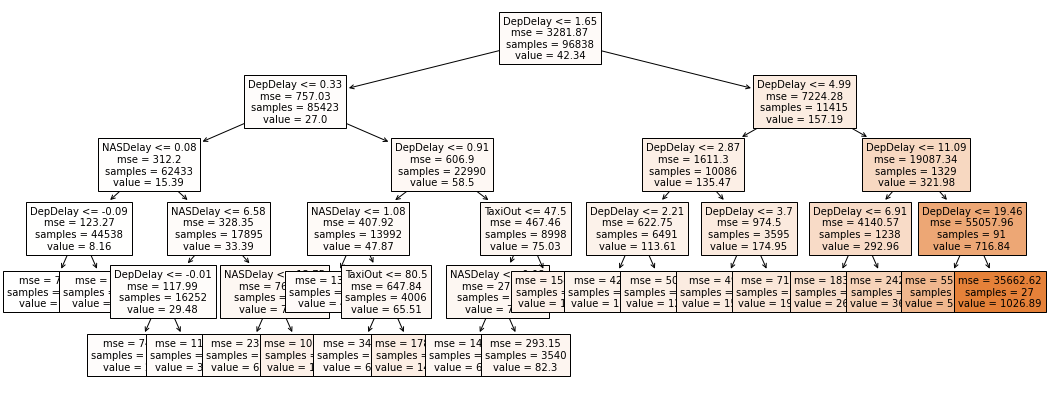

In [13]:
from sklearn.tree import plot_tree
fig, ax = plt.subplots(figsize=(18, 7))

print(f"Profundidad del árbol: {model1.get_depth()}")
print(f"Número de nodos terminales: {model1.get_n_leaves()}")

plot = plot_tree(
            decision_tree = model1,
            feature_names = df.drop(columns = "ArrDelay").columns,
            class_names   = 'ArrDelay',
            filled        = True,
            impurity      = True,
            fontsize      = 10,
            precision     = 2,
            ax            = ax
       )

In [14]:
importancia = pd.DataFrame({'attribute': df.drop(columns = "ArrDelay").columns,
                             'rank': model1.feature_importances_})

importancia.sort_values('rank', ascending=False)

,attribute,rank
2,DepDelay,0.946456
10,NASDelay,0.046507
5,TaxiOut,0.007037
0,ActualElapsedTime,0.000000
13,DepTime_sin,0.000000
20,dest,0.000000
19,origin_freq,0.000000
18,DayOfWeek_cos,0.000000
17,DayOfWeek_sin,0.000000
16,Month_cos,0.000000


In [15]:
y_pred = model1.predict(X_test)

model1.fit(X,y)
print("R-Squared on train dataset={}".format(model1.score(X_test,y_test)))
r2=model1.score(X_test,y_test)

model1.fit(X_test,y_test)   
print("R-Squared on test dataset={}".format(model1.score(X_test,y_test)))

mse = mean_squared_error(y_test, y_pred)
print('MSE: %.3f' % mse)
print('RMSE: %.3f' % (mse*(1/2.0)))

mae=mean_absolute_error(y_test, y_pred)
print('MAE: %.3f' % mae)

code='dt2'
process='Decision_Tree'
datab='standard'
depdelay='yes'

cur.execute("INSERT OR REPLACE INTO parametres(codi,proces,DepDelay, base_dades, MAE, R2, MSE) VALUES(?,?,?,?,?,?,?)",(code,process,depdelay,datab,'%.3f' % mae,'%.3f' % r2,'%.3f' % mse))
conn.commit()

R-Squared on train dataset=0.9361900521289696
R-Squared on test dataset=0.9373198749359438
MSE: 205.708
RMSE: 102.854
MAE: 9.383


##### Delete the attribute Departure Delay

In [16]:
dfdel=df.drop(['DepDelay'], axis=1)

In [17]:
X,y = dfdel.loc[:, dfdel.columns != 'ArrDelay'],dfdel.loc[:, dfdel.columns == 'ArrDelay']
X_train,X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)


model1 = DecisionTreeRegressor(min_samples_split=10,max_depth=6,min_samples_leaf=20,
                               max_leaf_nodes=20).fit(X_train, y_train,)

model1.fit(X,y)
print("R-Squared on train dataset={}".format(model1.score(X_test,y_test)))

model1.fit(X_test,y_test)   
print("R-Squared on test dataset={}".format(model1.score(X_test,y_test)))

y_pred = model1.predict(X_test)

model1.fit(X,y)
print("R-Squared on train dataset={}".format(model1.score(X_test,y_test)))
r2=model1.score(X_test,y_test)

model1.fit(X_test,y_test)   
print("R-Squared on test dataset={}".format(model1.score(X_test,y_test)))

mse = mean_squared_error(y_test, y_pred)
print('MSE: %.3f' % mse)
print('RMSE: %.3f' % (mse*(1/2.0)))

mae=mean_absolute_error(y_test, y_pred)
print('MAE: %.3f' % mae)

code='dt3'
process='Decision_Tree'
datab='standard'
depdelay='no'

cur.execute("INSERT OR REPLACE INTO parametres(codi,proces,DepDelay, base_dades, MAE, R2, MSE) VALUES(?,?,?,?,?,?,?)",(code,process,depdelay,datab,'%.3f' % mae,'%.3f' % r2,'%.3f' % mse))
conn.commit()

R-Squared on train dataset=0.8404027219387731
R-Squared on test dataset=0.8401963594613544
R-Squared on train dataset=0.8404027219387731
R-Squared on test dataset=0.8401963594613544
MSE: 524.455
RMSE: 262.228
MAE: 15.117




##### Eliminem les columnes que sembla no tenen influència en les prediccions

In [18]:
dfmin=df[['DepDelay','NASDelay','TaxiOut','ArrDelay']]
dfmin.head(3)

,DepDelay,NASDelay,TaxiOut,ArrDelay
0,1.756098,0.0,20.0,83
1,0.658537,0.0,13.0,47
2,-0.390244,0.0,9.0,6


In [19]:
X,y = dfmin.loc[:, dfmin.columns != 'ArrDelay'],dfmin.loc[:, dfmin.columns == 'ArrDelay']
X_train,X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

model = DecisionTreeRegressor(min_samples_split=10,max_depth=6,min_samples_leaf=20,
                               max_leaf_nodes=20).fit(X_train, y_train,)

model.fit(X,y)
print("R-Squared on train dataset={}".format(model.score(X_test,y_test)))

model.fit(X_test,y_test)   
print("R-Squared on test dataset={}".format(model.score(X_test,y_test)))

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print('MSE: %.3f' % mse)
print('RMSE: %.3f' % (mse*(1/2.0)))

mae=mean_absolute_error(y_test, y_pred)
print('MAE: %.3f' % mae)

code='dt4'
process='Decision_Tree'
datab='standard/min'
depdelay='yes'

cur.execute("INSERT OR REPLACE INTO parametres(codi,proces,DepDelay, base_dades, MAE, R2, MSE) VALUES(?,?,?,?,?,?,?)",(code,process,depdelay,datab,'%.3f' % mae,'%.3f' % r2,'%.3f' % mse))
conn.commit()

R-Squared on train dataset=0.9361900521289696
R-Squared on test dataset=0.9373198749359438
MSE: 205.708
RMSE: 102.854
MAE: 9.383






##### Try the same model with a non standaried database

In [20]:
df=pd.read_csv('delays_no25.csv', index_col=False, warn_bad_lines=True, error_bad_lines=False)
df=df.drop(['Unnamed: 0'], axis=1)
df.head()

,Month,DayOfWeek,DepTime,ArrTime,ActualElapsedTime,AirTime,ArrDelay,DepDelay,Distance,TaxiIn,...,Cancelled,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,origin_freq,dest,carrier_me
0,7,1,1851.0,151.0,240,204,7.0,8.0,1671,19.0,...,0,0,0.0,0.0,0.0,0.0,0.0,0.028770,0.017956,36.445019
1,2,5,1036.0,1142.0,66,33,83.0,73.0,130,6.0,...,0,0,0.0,0.0,83.0,0.0,0.0,0.000606,0.056271,45.370587
2,12,5,1842.0,2238.0,356,332,48.0,37.0,2556,5.0,...,0,0,23.0,0.0,11.0,0.0,14.0,0.030346,0.005212,39.881507
3,12,7,1635.0,1702.0,87,42,47.0,25.0,256,4.0,...,0,0,25.0,0.0,22.0,0.0,0.0,0.028770,0.025227,30.087884
4,12,3,1532.0,1641.0,69,55,36.0,42.0,377,3.0,...,0,0,0.0,0.0,0.0,0.0,36.0,0.015856,0.003103,30.087884


In [21]:
X,y = df.loc[:, df.columns != 'ArrDelay'],df.loc[:, df.columns == 'ArrDelay']
X_train,X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

model = DecisionTreeRegressor(min_samples_split=10,max_depth=6,min_samples_leaf=20,
                               max_leaf_nodes=20).fit(X_train, y_train,)

model.fit(X,y)
print("R-Squared on train dataset={}".format(model.score(X_test,y_test)))

model.fit(X_test,y_test)   
print("R-Squared on test dataset={}".format(model.score(X_test,y_test)))

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print('MSE: %.3f' % mse)
print('RMSE: %.3f' % (mse*(1/2.0)))

mae=mean_absolute_error(y_test, y_pred)
print('MAE: %.3f' % mae)

code='dt5'
process='Decision_Tree'
datab='no standard'
depdelay='yes'

cur.execute("INSERT OR REPLACE INTO parametres(codi,proces,DepDelay, base_dades, MAE, R2, MSE) VALUES(?,?,?,?,?,?,?)",(code,process,depdelay,datab,'%.3f' % mae,'%.3f' % r2,'%.3f' % mse))
conn.commit()

R-Squared on train dataset=0.9268239887743983
R-Squared on test dataset=0.9288356548121978
MSE: 227.035
RMSE: 113.517
MAE: 9.818




##### Delete Departure Delay

In [22]:
dfdel=df.drop(['DepDelay'], axis=1)

In [23]:
X,y = dfdel.loc[:, dfdel.columns != 'ArrDelay'],dfdel.loc[:, dfdel.columns == 'ArrDelay']
X_train,X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

model = DecisionTreeRegressor(min_samples_split=10,max_depth=6,min_samples_leaf=20,
                               max_leaf_nodes=20).fit(X_train, y_train,)

model.fit(X,y)
print("R-Squared on train dataset={}".format(model.score(X_test,y_test)))

model.fit(X_test,y_test)   
print("R-Squared on test dataset={}".format(model.score(X_test,y_test)))

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print('MSE: %.3f' % mse)
print('RMSE: %.3f' % (mse*(1/2.0)))

mae=mean_absolute_error(y_test, y_pred)
print('MAE: %.3f' % mae)

code='dt6'
process='Decision_Tree'
datab='no standard'
depdelay='no'

cur.execute("INSERT OR REPLACE INTO parametres(codi,proces,DepDelay, base_dades, MAE, R2, MSE) VALUES(?,?,?,?,?,?,?)",(code,process,depdelay,datab,'%.3f' % mae,'%.3f' % r2,'%.3f' % mse))
conn.commit()

R-Squared on train dataset=0.8445624030896794
R-Squared on test dataset=0.8452424438135118
MSE: 493.721
RMSE: 246.861
MAE: 14.717


##### Check the SQL dataset (or delete it if needed)

In [24]:
#cur.execute('''DELETE FROM parametres''')
#conn.commit()
print(pd.read_sql_query("SELECT * from parametres", conn))

  codi         proces DepDelay    base_dades     MAE     R2      MSE
0  dt1  Decision_Tree      yes      standard   5.826  0.977   83.016
1  dt2  Decision_Tree      yes      standard   9.383  0.936  205.708
2  dt3  Decision_Tree       no      standard  15.117  0.840  524.455
3  dt4  Decision_Tree      yes  standard/min   9.383  0.840  205.708
4  dt5  Decision_Tree      yes   no standard   9.818  0.840  227.035
5  dt6  Decision_Tree       no   no standard  14.717  0.840  493.721
